In [1]:
import numpy as np
from NonlinearController.mpc_utils import *
from NonlinearController.controllers import *
from NonlinearController.model_utils import *
from NonlinearController.lpv_embedding import *
from NonlinearController.systems import UnbalancedDisc
import deepSI
import qpsolvers as qp

In [2]:
##################  System  #######################
system = UnbalancedDisc(dt=0.1)
system.reset_state()

##################  MPC variable specification  #######################
model = deepSI.load_system("NonlinearController/trained_models/unbalanced/ObserverUnbalancedDisk_dt01_nab_4_SNR_30_e250")

Nc=5; nr_iterations = 4; nr_sim_steps = 20

reference = 0

In [3]:
class velocity_lpv_embedder():
    def __init__(self, ss_enc, Nc, n_stages=20):
        self.nx = ss_enc.nx
        self.nu = ss_enc.nu if ss_enc.nu is not None else 1
        self.ny = ss_enc.ny if ss_enc.ny is not None else 1

        self.Nc = Nc

        self.lpv_A, self.lpv_B, self.lpv_C = velocity_lpv_embedding(ss_enc,n_stages=n_stages)
        self.lpv_A_Nc = self.lpv_A.map(self.Nc, "thread", 32)
        self.lpv_B_Nc = self.lpv_B.map(self.Nc, "thread", 32)
        self.lpv_C_Nc = self.lpv_C.map(self.Nc, "thread", 32)

    def __call__(self, X, U):
        X_1 = np.hstack(np.split(X[:-nx],Nc))
        dX0 = np.hstack(np.split(X[nx:] - X[:-nx],Nc))
        U_1 = np.hstack(np.split(U[:-nu],Nc))
        dU0 = np.hstack(np.split(U[nu:] - U[:-nu],Nc))
        
        pA = self.lpv_A_Nc(X_1, dX0, U_1, dU0)
        pB = self.lpv_B_Nc(X_1, dX0, U_1, dU0)
        pC = self.lpv_C_Nc(X_1, dX0, U_1, dU0)

        return self.reshapeEmbedding(pA, pB, pC)

    def reshapeEmbedding(self, pA,pB,pC):
        list_A = np.zeros([self.Nc*self.nx, self.nx])
        list_B = np.zeros([self.Nc*self.nx, self.nu])
        list_C = np.zeros([self.Nc*self.ny, self.nx])

        for i in range(self.Nc):
            list_A[(self.nx*i):(self.nx*i+self.nx),:] = pA[:,i*self.nx:(i+1)*self.nx]

        for i in range(Nc):
            list_B[(self.nx*i):(self.nx*i+self.nx),:] = pB[:,i*self.nu:(i+1)*self.nu]

        for i in range(Nc):
            list_C[(self.ny*i):(self.ny*i+self.ny),:] = pC[:,i*self.nx:(i+1)*self.nx]

        return list_A, list_B, list_C

In [4]:
##################  Utility functions  #######################

# def reshapeStacked(X, Nc):
#     return np.hstack(np.split(X,Nc))

def differenceVector(X_1, nx):
    return X_1[nx:] - X_1[:-nx]

def extendABC(list_A, list_B, list_C, nx, ny):
    nz = nx+ny
    list_ext_A = np.zeros((nz*Nc,nz))
    list_ext_B = np.zeros((nz*Nc,nu))

    for i in range(Nc):
        list_ext_A[(i*nz):(i*nz+ny),:ny] = np.eye(ny)
        list_ext_A[(i*nz):(i*nz+ny),ny:nz] = list_C[(ny*i):(ny*i+ny),:]
        list_ext_A[(i*nz+ny):(i*nz+nz),ny:nz] = list_A[(nx*i):(nx*i+nx),:]

    for i in range(Nc):
        list_ext_B[(i*nz+ny):(i*nz+nz),:] = list_B[(nx*i):(nx*i+nx),:]

    list_ext_C = np.zeros((ny*Nc,nz))

    for i in range(Nc):
        list_ext_C[(i*ny):(i*ny+ny),:ny] = np.eye(ny)
        list_ext_C[(i*ny):(i*ny+ny),ny:nz] = list_C[(ny*i):(ny*i+ny),:]
    
    return list_ext_A, list_ext_B, list_ext_C

def extendState(Y_1, dX0, nx, ny):
    nz = nx+ny
    Z0 = np.zeros((Nc*nz,1))

    for i in range(Nc):
        Z0[(nz*i):(nz*i+ny),:] = Y_1[ny*i:(ny*i+ny),:]
        Z0[(nz*i+ny):(nz*i+nz),:] = dX0[nx*i:(nx*i+nx),:]

    return Z0

def decodeState(Z0, nx, ny):
    nz = nx+ny
    Y_1 = np.zeros((Nc*ny,1))
    dX0 = np.zeros((Nc*nx,1))

    for i in range(Nc):
        Y_1[ny*i:(ny*i+ny),:] = Z0[(nz*i):(nz*i+ny),:]
        dX0[nx*i:(nx*i+nx),:] = Z0[(nz*i+ny):(nz*i+nz),:]

    return Y_1, dX0


In [7]:
##################  Offline Computation  #######################
nx = model.nx
nu = model.nu if model.nu is not None else 1
ny = model.ny if model.ny is not None else 1
nz = nx+ny

norm = model.norm

R = np.eye(nu); Q = np.eye(nz)
Psi = get_Psi(Nc, R)
Omega = get_Omega(Nc, Q)

embedder = velocity_lpv_embedder(model, Nc)


r = (np.tile(np.hstack((norm_output(reference, norm), np.zeros((nx,)))), Nc)[np.newaxis]).T
#r = np.zeros((Nc*nz,0))
#r_norm = norm_output

# initial predicted states, input, and output
X_1 = np.arange((Nc+1)*nx)[np.newaxis].T*0.1
U_1 = np.arange((Nc+1)*nu)[np.newaxis].T*0.1
Y_1 = np.arange((Nc)*ny)[np.newaxis].T*0.1

##################  Logging  #######################
log_q = np.zeros((ny,nr_sim_steps))

In [8]:
##################  Online Computation  #######################

#++++++++++++++++++ start simulation step +++++++++++++++++++++++
for k in range(nr_sim_steps):
    #++++++++++++++++++ start iteration +++++++++++++++++++++++
    for iterations in range(nr_iterations):
        # determine predicted velocity states and output
        dX0 = differenceVector(X_1, nx)
        dU0 = differenceVector(U_1, nu)
        # determine extended state from predicted output and velocity states
        Z0 = extendState(Y_1, dX0, nx, ny)

        # determine lpv state space dependencies
        list_A, list_B, list_C = embedder(X_1, U_1)
        list_ext_A, list_ext_B, list_ext_C = extendABC(list_A, list_B, list_C, nx, ny)

        # describe optimization problem
        Phi = get_Phi(list_ext_A, Nc, nz)
        Gamma = get_Gamma(list_ext_A, list_ext_B, Nc, nz, nu)
        G = Psi + Gamma.T @ Omega @ Gamma
        F = 2*Gamma.T @ Omega.T @ (Phi @ Z0[:nz] - r) # reference should be normalized and shaped into correct form
        # solve for optimal U over prediction horizon
        dU0[:,0] = qp.solve_qp(G,F,solver="osqp")

        # predict states
        Z1 = Phi @ Z0[:nz] + Gamma @ dU0
        # split extended state up into ouputs and velocity states
        Y0, dX1 = decodeState(Z1, nx, ny)
        # overwrite previous predicted states and output with new predicted states and output
        Y_1[ny:,0] = Y0[:-ny,0]; dX0[nx:,0] = dX1[:-nx,0]
        # determine new X_1 states from known x0 and predicted dX0
        for i in range(2,Nc+1):
            X_1[(i*nx):(i*nx+nx),:] = dX0[((i-1)*nx):((i-1)*nx+nx),:] + X_1[((i-1)*nx):((i-1)*nx+nx),:]

        for i in range(2,Nc+1):
            U_1[(i*nu):(i*nu+nu),:] = dU0[((i-1)*nu):((i-1)*nu+nu),:] + U_1[((i-1)*nu):((i-1)*nu+nu),:]
    #++++++++++++++++++ end iteration +++++++++++++++++++++++
    
    # determine input from optimal velocity input
    u0 = dU0[:nu,0] + U_1[:nu,0]
    # denormalize input
    w0 = denorm_input(u0, norm)
    # measure output then apply input
    q0 = system.measure_act(w0[0]) # maybe change this to act measure / deal with dimension of input
    log_q[:,k] = q0
    # normalize output
    y0 = norm_output(q0, norm)

    # shift predicted states, input, and output
    
#++++++++++++++++++ end simulation step +++++++++++++++++++++++

c:\Users\20182739\AppData\Local\Programs\Python\Python39\lib\site-packages\qpsolvers\solvers\typing.py:48: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(


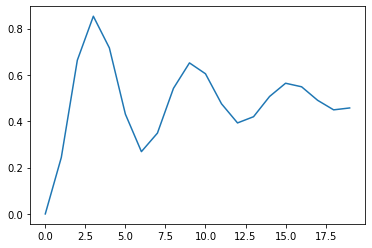

In [9]:
plt.plot(log_q[0,:])